In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia

In [ ]:
## Input Variables
## example: NGC6397

name = "NGC6397"

## Galactic coordinates of the globular cluster
## example: Aladin lite can search the cluster by target identifier: https://aladin.cds.unistra.fr/AladinLite/
ra_new = 265.175375
dec_new = -53.674333

## Proper motion coordinates of the cluster
## example database: https://simbad.u-strasbg.fr/simbad/sim-basicIdent=m33&submit=SIMBAD+search
centerx, centery = -17.600	, 3.300	

## Cutoff radius 
rad, rad2 = 0, 1.5

In [3]:
## Load tables and download the data from the Gaia archive

tables = Gaia.load_tables(only_names=True)

job = Gaia.launch_job_async(
    f"SELECT gaia_source.source_id, gaia_source.ra, gaia_source.dec, "
    f"gaia_source.pmra, gaia_source.pmdec, gaia_source.phot_g_mean_mag, "
    f"gaia_source.bp_rp, gaia_source.astrometric_params_solved, "
    f"gaia_source.phot_g_mean_flux, gaia_source.phot_bp_mean_flux, "
    f"gaia_source.phot_rp_mean_flux, "
    f"DISTANCE({ra_new}, {dec_new}, ra, dec) "
    f"FROM gaiadr3.gaia_source "
    f"WHERE DISTANCE({ra_new}, {dec_new}, ra, dec) < 5./60. "
    f"AND phot_bp_mean_mag < 20.3",
    dump_to_file=True
)

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


In [4]:
df = job.get_results().to_pandas()

# Filter out rows where 'astrometric_params_solved' is not 3
df = df[df['astrometric_params_solved'] != 3]

# Compute squared distance for filtering
distance_sq = (df.pmdec - centerx) ** 2 + (df.pmra - centery) ** 2
df = df[(distance_sq > rad**2) & (distance_sq < rad2**2)]

# Filter out rows with NaN in 'bp_rp'
df = df[df['bp_rp'].notna()]

In [5]:
## Corrected BP and RP flux excess (Riello, M. et al 2021)

def c(i_bp, i_rp, i_g):
    return (i_bp + i_rp) / i_g

# Constants
c0 = 0.0059898 
c1 = 8.817481e-11  
c3 = 7.618399

def sigma_c(g_m):
    return c0 + c1 * g_m**c3

def f(g_bprp):
    return (
        1.154360 + 0.033772 * g_bprp + 0.032277 * g_bprp**2
        if g_bprp < 0.5
        else 1.162004 + 0.011464 * g_bprp + 0.049255 * g_bprp**2
    )

df['c'] = df.apply(lambda row: c(row['phot_bp_mean_flux'], row['phot_rp_mean_flux'], row['phot_g_mean_flux']), axis=1)
df['sigma_c'] = df['phot_g_mean_mag'].apply(sigma_c)
df['c_star'] = df['bp_rp'].apply(f)
df['c_diff'] = df['c'] - df['c_star']

# Apply filtering: Keep rows where c_diff is within ±sigma_c 
df = df[(df['c_diff'] >= -df['sigma_c']) & (df['c_diff'] <= df['sigma_c'])]

## Export the data 
np.savetxt(f"{name}.txt", df[['bp_rp','phot_g_mean_mag']].to_numpy(), fmt="%.6f", delimiter=" ")

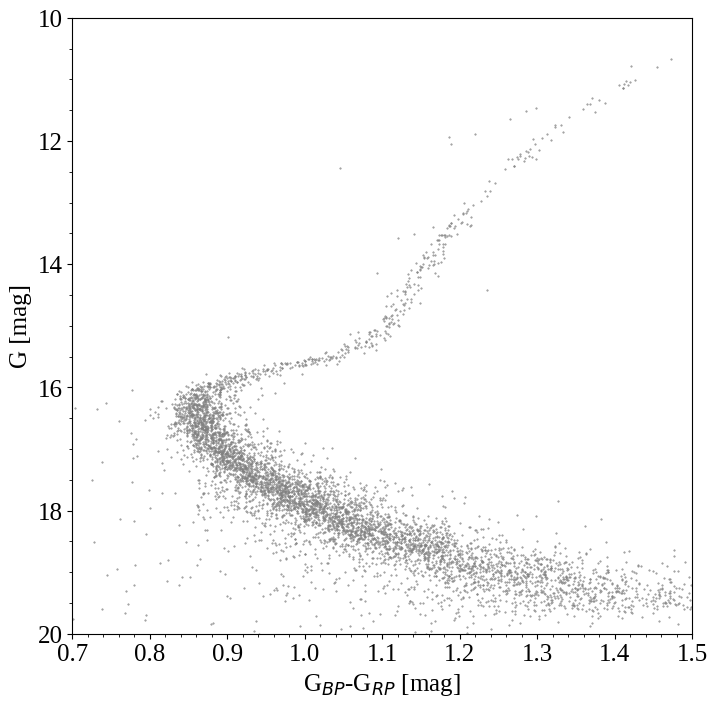

In [6]:
## Display the result Color Magnitude Diagram of the Cluster - optional

plt.rcParams.update({'font.size': 18})
plt.rcParams["font.family"] = "Liberation Serif"

fig = plt.figure(figsize=(8,8))
plt.gca().invert_yaxis()
plt.xlim(0.7, 1.5)
plt.ylim(20, 10)
plt.minorticks_on()
plt.scatter(df['bp_rp'],df['phot_g_mean_mag'], s=0.2,c='grey')

plt.xlabel('G$_{BP}$-G$_{RP}$ [mag]')
plt.ylabel('G [mag]')
#plt.savefig(f"{name}.png")
plt.show()